## Univariate data analyses - NHANES case study

Here we will demonstrate how to use Python and [Pandas](https://pandas.pydata.org/) to perform some basic analyses with univariate data, using the 2015-2016 wave of the [NHANES](https://www.cdc.gov/nchs/nhanes/index.htm) cross-sectional study to illustrate the techniques.

The following import statements make the libraries that we will need available.  Note that in a Jupyter notebook, you should generally use the `%matplotlib inline` directive so that any plots that you generate are shown in the notebook.  This directive is omitted when running a script outside of the Jupyter environment.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

Next we will load the NHANES data from a file into a Pandas dataframe.

In [3]:
da = pd.read_csv("C:/Users/ziadt/Desktop/Projects/Coursera - Understanding and Visualizing Data with Python/datasets/nhanes_2015_2016.csv")

### Frequency tables

The [value_counts](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.value_counts.html) method can be used to determine the number of times that each distinct value of a variable occurs in a data set.  In statistical terminology, this is the "frequency distribution" of the variable.  Below we show the frequency distribution of the [DMDEDUC2](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#DMDEDUC2) variable, which is a variable that reflects a person's level of educational attainment.  The `value_counts` method produces a table with two columns.  The first column contains all distinct observed values for the variable.  The second column contains the number of times that each of these values occurs.  Note that the table returned by `value_counts` is actually a Pandas data frame, so can be further processed using any Pandas methods for working with data frames.

The numbers 1, 2, 3, 4, 5, 9 seen below are integer codes for the 6 possible non-missing values of the DMDEDUC2 variable.  The meaning of these codes is given in the NHANES codebook located [here](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#DMDEDUC2), and will be discussed further below.  This table shows, for example, that 1621 people in the data file have DMDEDUC=4, which indicates that the person has completed some college, but has not graduated with a four-year degree.

In [4]:
da.DMDEDUC2.value_counts()

DMDEDUC2
4.0    1621
5.0    1366
3.0    1186
1.0     655
2.0     643
9.0       3
Name: count, dtype: int64

Note that the [value_counts](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html) method excludes missing values.  We confirm this below by adding up the number of observations with a DMDEDUC2 value equal to 1, 2, 3, 4, 5, or 9 (there are 5474 such rows), and comparing this to the total number of rows in the data set, which is 5735. This tells us that there are 5735 - 5474 = 261 missing values for this variable (other variables may have different numbers of missing values).

In [5]:
print(da.DMDEDUC2.value_counts().sum())
print(1621 + 1366 + 1186 + 655 + 643 + 3) # Manually sum the frequencies
print(da.shape)

5474
5474
(5735, 28)


Another way to obtain this result is to locate all the null (missing) values in the data set using the [isnull](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.isnull.html) Pandas function, and count the number of such locations.

In [6]:
pd.isnull(da.DMDEDUC2).sum() # Get the number of missing values

np.int64(261)

In some cases it is useful to [replace](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.replace.html) integer codes with a text label that reflects the code's meaning.  Below we create a new variable called 'DMDEDUC2x' that is recoded with text labels, then we generate its frequency distribution.

In [7]:
da["DMDEDUC2x"] = da.DMDEDUC2.replace({1: "<9", 2: "9-11", 3: "HS/GED", 4: "Some college/AA", 5: "College", 
                                       7: "Refused", 9: "Don't know"}) # Recode the variable into a more readable format
da.DMDEDUC2x.value_counts()

DMDEDUC2x
Some college/AA    1621
College            1366
HS/GED             1186
<9                  655
9-11                643
Don't know            3
Name: count, dtype: int64

We will also want to have a relabeled version of the gender variable, so we will construct that now as well.  We will follow a convention here of appending an 'x' to the end of a categorical variable's name when it has been recoded from numeric to string (text) values.

In [8]:
da["RIAGENDRx"] = da.RIAGENDR.replace({1: "Male", 2: "Female"})

For many purposes it is more relevant to consider the proportion of the sample with each of the possible category values, rather than the number of people in each category.  We can do this as follows:

In [9]:
x = da.DMDEDUC2x.value_counts()  # x is just a name to hold this value temporarily
x / x.sum()

DMDEDUC2x
Some college/AA    0.296127
College            0.249543
HS/GED             0.216661
<9                 0.119657
9-11               0.117464
Don't know         0.000548
Name: count, dtype: float64

According to the results above, 12% of the people who have a non-missing education value have completed less than 9 years of formal education.

In some cases we will want to treat the missing response category as another category of observed response, rather than ignoring it when creating summaries.  Below we create a new category called "Missing", and assign all missing values to it usig [fillna](https://pandas.pydata.org/pandas-docs/stable/missing_data.html#filling-missing-values-fillna).  Then we recalculate the frequency distribution.  We see that 4.6% of the responses are missing.

In [10]:
da["DMDEDUC2x"] = da.DMDEDUC2x.fillna("Missing") # fillna is used to fill missing values with a specified value
x = da.DMDEDUC2x.value_counts()
x / x.sum()

DMDEDUC2x
Some college/AA    0.282650
College            0.238187
HS/GED             0.206800
<9                 0.114211
9-11               0.112119
Missing            0.045510
Don't know         0.000523
Name: count, dtype: float64

### Numerical summaries

A quick way to get a set of numerical summaries for a quantitative variable is with the [describe](https://pandas.pydata.org/pandas-docs/stable/basics.html#summarizing-data-describe) data frame method.  Below we demonstrate how to do this using the body weight variable ([BMXWT](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/BMX_I.htm#BMXWT)).  As with many surveys, some data values are missing, so we explicitly drop the missing cases using the [dropna](https://pandas.pydata.org/pandas-docs/stable/missing_data.html#dropping-axis-labels-with-missing-data-dropna) method before generating the summaries.

In [18]:
da["BMXWT"].dropna().describe()

count    5666.000000
mean       81.342676
std        21.764409
min        32.400000
25%        65.900000
50%        78.200000
75%        92.700000
max       198.900000
Name: BMXWT, dtype: float64

It's also possible to calculate individual summary statistics from one column of a data set.  This can be done using Pandas methods, or with numpy functions:

In [19]:
x = da["BMXWT"].dropna()  # Extract all non-missing values of BMXWT into a variable called 'x'
print(x.mean()) # Pandas method
print(np.mean(x)) # Numpy function

print(x.median())
print(np.percentile(x, 50))  # 50th percentile, same as the median
print(np.percentile(x, 75))  # 75th percentile
print(x.quantile(0.75)) # Pandas method for quantiles, equivalent to 75th percentile

81.34267560889516
81.34267560889516
78.2
78.2
92.7
92.7


Next we look at frequencies for a systolic blood pressure measurement ([BPXSY1](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/BPX_I.htm#BPXSY1)).  "BPX" here is the NHANES prefix for blood pressure measurements, "SY" stands for "systolic" blood pressure (blood pressure at the peak of a heartbeat cycle), and "1" indicates that this is the first of three systolic blood presure measurements taken on a subject.

A person is generally considered to have pre-hypertension when their systolic blood pressure is between 120 and 139, or their diastolic blood pressure is between 80 and 89.  Considering only the systolic condition, we can calculate the proprotion of the NHANES sample who would be considered to have pre-hypertension. 

In [20]:
np.mean((da.BPXSY1 >= 120) & (da.BPXSY1 <= 139))  # "&" means "and"

np.float64(0.366870095902354)

Next we calculate the propotion of NHANES subjects who are pre-hypertensive based on diastolic blood pressure.

In [21]:
np.mean((da.BPXDI1 >= 80) & (da.BPXDI2 <= 89))

np.float64(0.14803836094158676)

Finally we calculate the proportion of NHANES subjects who are pre-hypertensive based on either systolic or diastolic blood pressure.  Since some people are pre-hypertensive under both criteria, the proportion below is less than the sum of the two proportions calculated above.  The combined systolic and diastolic condition for pre-hypertension is somewhat complex, so below we construct temporary variables 'a' and 'b' that hold the systolic and diastolic pre-hypertensive status separately, then combine them with a "logical or" to obtain the final status for each subject.

In [22]:
a = (da.BPXSY1 >= 120) & (da.BPXSY2 <= 139)
b = (da.BPXDI1 >= 80) & (da.BPXDI2 <= 89)
print(np.mean(a | b))  # "|" means "or"

0.43975588491717527


Blood pressure measurements are affected by a phenomenon called "white coat hypertension", in which a subject's bood pressure may be slightly elevated if they are nervous when interacting with health care providers.  Typically this effect subsides if the blood pressure is measured several times in sequence.  In NHANES, both systolic and diastolic blood pressure are meausred three times for each subject (e.g. [BPXSY2](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/BPX_I.htm#BPXSY2) is the second measurement of systolic blood pressure).  We can calculate the extent to which white coat anxiety is present in the NHANES data by looking a the mean difference between the first two systolic or diastolic blood pressure measurements.

In [23]:
print(np.mean(da.BPXSY1 - da.BPXSY2))
print(np.mean(da.BPXDI1 - da.BPXDI2))

0.6749860309182343
0.3490407897187558


These mean differences are positive -- the first systolic blood pressure measurement is around 0.67 mm Hg greater than the second systolic blood pressure measurement, and the first diastolic blood pressure measurement is around 0.35 mm Hg greater than the second diastolic blood pressure measurement.  This is consistent with the presence of "white coat hypertension".

### Graphical summaries

Quantitative variables can be effectively summarized graphically.  Below we see the distribution of body weight (in Kg), shown as a histogram.  The distribution is evidently right-skewed.

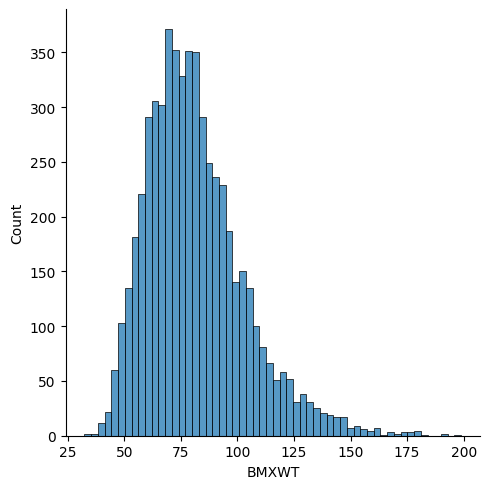

In [24]:
sns.displot(da.BMXWT.dropna())

Next we look at the histogram of systolic blood pressure measurements.  You can see that there is a tendency for the measurements to be rounded to the nearest 5 or 10 units.

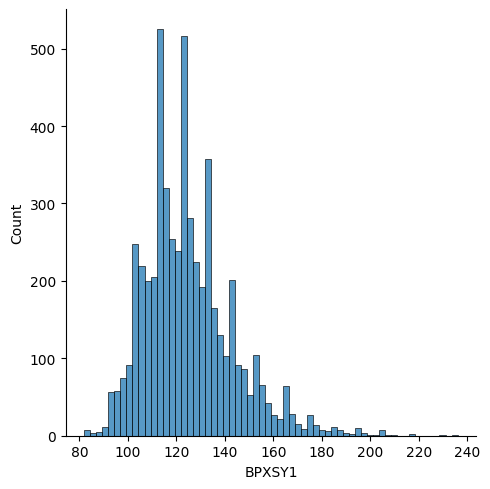

In [29]:
sns.displot(da.BPXSY1.dropna()) # why dropna()? to remove missing values from the data before plotting it to avoid errors

To compare several distributions, we can use side-by-side boxplots.  Below we compare the distributions of the first and second systolic blood pressure measurements ([BPXSY1](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/BPX_I.htm#BPXSY1), BPXSY2), and the first and second diastolic blood pressure measurements ([BPXDI1](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/BPX_I.htm#BPXDI1), BPXDI2). As expected, diastolic measurements are substantially lower than systolic measurements.  Above we saw that the second blood pressure reading on a subject tended on average to be slightly lower than the first measurement.  This difference was less than 1 mm/Hg, so is not visible in the "marginal" distributions shown below.

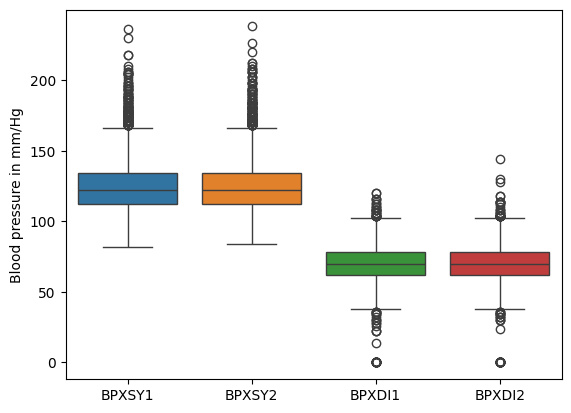

In [30]:
bp = sns.boxplot(data=da.loc[:, ["BPXSY1", "BPXSY2", "BPXDI1", "BPXDI2"]])
_ = bp.set_ylabel("Blood pressure in mm/Hg")

### Stratification

One of the most effective ways to get more information out of a dataset is to divide it into smaller, more uniform subsets, and analyze each of these "strata" on its own.  We can then formally or informally compare the findings in the different strata.  When working with human subjects, it is very common to stratify on demographic factors such as age, sex, and race.

To illustrate this technique, consider blood pressure, which is a value that tends to increase with age.  To see this trend in the NHANES data, we can [partition](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.cut.html) the data into age strata, and construct side-by-side boxplots of the systolic blood pressure (SBP) distribution within each stratum.  Since age is a quantitative variable, we need to create a series of "bins" of similar SBP values in order to stratify the data.  Each box in the figure below is a summary of univariate data within a specific population stratum (here defined by age).

<Axes: xlabel='agegrp', ylabel='BPXSY1'>

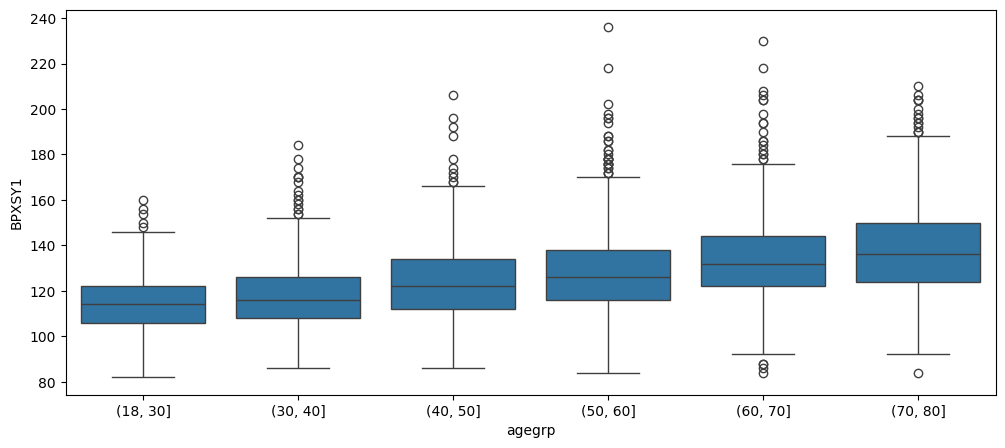

In [31]:
da["agegrp"] = pd.cut(da.RIDAGEYR, [18, 30, 40, 50, 60, 70, 80]) # Create age strata based on these cut points
plt.figure(figsize=(12, 5))  # Make the figure wider than default (12cm wide by 5cm tall)
sns.boxplot(x="agegrp", y="BPXSY1", data=da)  # Make boxplot of BPXSY1 stratified by age group

When stratifying on two factors (here age and gender), we can group the boxes first by age, and within age bands by gender, as above, or we can do the opposite -- group first by gender, and then within gender group by age bands.  Each approach highlights a different aspect of the data.

<Axes: xlabel='RIAGENDRx', ylabel='BPXSY1'>

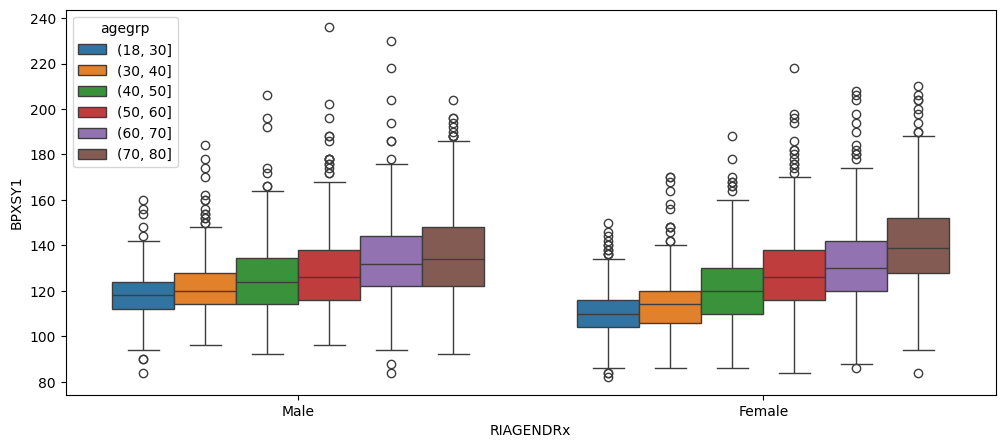

In [34]:
da["agegrp"] = pd.cut(da.RIDAGEYR, [18, 30, 40, 50, 60, 70, 80])
plt.figure(figsize=(12, 5))
sns.boxplot(x="RIAGENDRx", y="BPXSY1", hue="agegrp", data=da)

Stratification can also be useful when working with categorical variables.  Below we look at the frequency distribution of educational attainment ("DMDEDUC2") within 10-year age bands.  While "some college" is the most common response in all age bands, up to around age 60 the second most common response is "college" (i.e. the person graduated from college with a four-year degree). However for people over 50, there are as many or more people with only high school or general equivalency diplomas (HS/GED) than there are college graduates. 

**Note on causality and confounding:** An important role of statistics is to aid researchers in identifying causes underlying observed differences.  Here we have seen differences in both blood pressure and educational attainment based on age.  It is plausible that aging directly causes blood pressure to increase.  But in the case of educational attainment, this is actually a "birth cohort effect".  NHANES is a cross sectional survey (all data for one wave were collected at a single point in time). People who were, say, 65 in 2015 (when these data were collected), were college-aged around 1970, while people who were in their 20's in 2015 were college-aged in around 2010 or later.  Over the last few decades, it has become much more common for people to at least begin a college degree than it was in the past.  Therefore, younger people as a group have higher educational attainment than older people as a group.  As these young people grow older, the cross sectional relationship between age and educational attainment will change.

In [37]:
da.groupby("agegrp")["DMDEDUC2x"].value_counts()

C:\Users\ziadt\AppData\Local\Temp\ipykernel_20596\2928754252.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  da.groupby("agegrp")["DMDEDUC2x"].value_counts()


agegrp    DMDEDUC2x      
(18, 30]  Some college/AA    364
          College            278
          HS/GED             237
          Missing            128
          9-11                99
          <9                  47
          Don't know           0
(30, 40]  Some college/AA    282
          College            264
          HS/GED             182
          9-11               111
          <9                  93
          Don't know           0
          Missing              0
(40, 50]  Some college/AA    262
          College            260
          HS/GED             171
          9-11               112
          <9                  98
          Don't know           0
          Missing              0
(50, 60]  Some college/AA    258
          College            220
          HS/GED             220
          9-11               122
          <9                 104
          Don't know           0
          Missing              0
(60, 70]  Some college/AA    238
          HS/GED 

We can also stratify jointly by age and gender to explore how educational attainment varies by both of these factors simultaneously.  In doing this, it is easier to interpret the results if we [pivot](https://pandas.pydata.org/pandas-docs/stable/reshaping.html#reshaping-by-stacking-and-unstacking) the education levels into the columns, and normalize the counts so that they sum to 1.  After doing this, the results can be interpreted as proportions or probabilities.  One notable observation from this table is that for people up to age around 60, women are more likely to have graduated from college than men, but for people over aged 60, this relationship reverses.

In [38]:
dx = da.loc[~da.DMDEDUC2x.isin(["Don't know", "Missing"]), :]  # Eliminate rare/missing values
dx = dx.groupby(["agegrp", "RIAGENDRx"])["DMDEDUC2x"]
dx = dx.value_counts()
dx = dx.unstack() # Restructure the results from 'long' to 'wide'
dx = dx.apply(lambda x: x/x.sum(), axis=1) # Normalize within each stratum to get proportions
print(dx.to_string(float_format="%.3f"))  # Limit display to 3 decimal places

DMDEDUC2x           9-11    <9  College  HS/GED  Some college/AA
agegrp   RIAGENDRx                                              
(18, 30] Female    0.080 0.049    0.282   0.215            0.374
         Male      0.117 0.042    0.258   0.250            0.333
(30, 40] Female    0.089 0.097    0.314   0.165            0.335
         Male      0.151 0.103    0.251   0.227            0.269
(40, 50] Female    0.110 0.106    0.299   0.173            0.313
         Male      0.142 0.112    0.274   0.209            0.262
(50, 60] Female    0.117 0.102    0.245   0.234            0.302
         Male      0.148 0.123    0.231   0.242            0.256
(60, 70] Female    0.118 0.188    0.195   0.206            0.293
         Male      0.135 0.151    0.233   0.231            0.249
(70, 80] Female    0.105 0.225    0.149   0.240            0.281
         Male      0.113 0.180    0.237   0.215            0.255


C:\Users\ziadt\AppData\Local\Temp\ipykernel_20596\554239541.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dx = dx.groupby(["agegrp", "RIAGENDRx"])["DMDEDUC2x"]
